In [183]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import re
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

In [184]:
# DEMO = False
# WRITE_ERRORS_TO_FILE = True

In [185]:

# if DEMO:
#     CHARTEVENTS_BY_ICUSTAY_ID = 'data_demo/parquet/'
#     REDUCED_CE_BY_ICUSTAY_ID = 'data_demo/samples/'
#     NUMERICAL_BY_ICUSTAY_ID = 'data_demo/samples_numerical/'
#     STATB_BY_ICUSTAY_ID = 'data_demo/samples_statB/'
#     STATB_CSV_BY_ICUSTAY_ID = 'data_demo/samples_statB_csv/'
# else:

CHARTEVENTS_BY_ICUSTAY_ID = 'data/parquet/'
REDUCED_CE_BY_ICUSTAY_ID = 'data/samples/'
NUMERICAL_BY_ICUSTAY_ID = 'data/samples_numerical/'
STATB_BY_ICUSTAY_ID = 'data/samples_statB/'
DEMO_BY_ICUSTAY_ID = 'data/samples_demographics/'
ICD9_BY_ICUSTAY_ID = 'data/samples_icd9/'
CHARTEVENTS_FILENAME = 'mimic-iii/CHARTEVENTS.csv'
DIAGNOSES_FILENAME = 'mimic-iii/DIAGNOSES_ICD.csv'
READMISSION_FILENAME = 'data/readmission.csv'
EMBEDDED_FILENAME = 'resources/embedded.parquet'
ANNOTATION_FILENAME = 'data/anotation.csv'
STEP_FAIL_FILE = 'Step9_failed.txt'
BASELINE_FILENAME = 'data/baseline_data.csv'


In [216]:
K_FOLDS = 5
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.5
RANDOM_STATE = 1234
EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
BETA = 0.9

In [187]:
def reset_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

In [188]:
class ReadmissionDataset(Dataset):
    def __init__(self, annotations_file, numerical_dir=None, icd9_dir=None, demo_dir=None):
        self.labels = pd.read_csv(annotations_file)
        self.numerical_dir = numerical_dir
        # self.statB_dir = statB_dir
        self.icd9_dir = icd9_dir
        self.demo_dir = demo_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.numerical_dir:
            numerical_path = os.path.join(self.numerical_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            data = pd.read_parquet(numerical_path).to_numpy()
        if self.icd9_dir:
            icd9_path = os.path.join(self.icd9_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            icd9 = pd.read_parquet(icd9_path).reset_index(drop=True).to_numpy()
            icd9 = np.vstack([icd9]*data.shape[0])
            data = np.hstack([data, icd9]) 
            # assert icd9.shape[1] == 300, f'Stay = {self.labels.iloc[idx, 0]}'
        if self.demo_dir:
            demo_path = os.path.join(self.demo_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            demo = pd.read_parquet(demo_path).reset_index(drop=True).to_numpy()
            demo = np.vstack([demo]*data.shape[0])
            data = np.hstack([data, demo])
            # assert demo.shape[1] == 4, f'Stay = {self.labels.iloc[idx, 0]}'

        data = np.nan_to_num(data)
        data = data.astype(np.float32)
        label = np.ndarray((1,1))
        label[0,0] = self.labels.iloc[idx, 1]
        
        return data, label

In [189]:
dataset = ReadmissionDataset(ANNOTATION_FILENAME, numerical_dir=NUMERICAL_BY_ICUSTAY_ID, icd9_dir=ICD9_BY_ICUSTAY_ID, demo_dir=DEMO_BY_ICUSTAY_ID)

In [190]:
train_dataset, remaining = train_test_split(dataset, train_size=TRAIN_SPLIT, random_state=RANDOM_STATE,shuffle=False)
valid_dataset, test_dataset = train_test_split(remaining, test_size=TEST_SPLIT, random_state=RANDOM_STATE,shuffle=False)

In [191]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [192]:
DROPOUT = 0.5

In [222]:
class LSTMCNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LSTMCNN, self).__init__()
        
        
        self.lstm1 = torch.nn.LSTM(338,16,num_layers=2, bidirectional=True, dropout=DROPOUT, batch_first=True)
        self.lstm2 = torch.nn.LSTM(32,16,num_layers=4, bidirectional=False, dropout=DROPOUT, batch_first=True)
        self.act1 = torch.nn.Tanh()


        self.conv1 = torch.nn.Conv1d(48, 100, padding=16, kernel_size=2)
        self.conv2 = torch.nn.Conv1d(48, 100, padding=16, kernel_size=3)
        self.conv3 = torch.nn.Conv1d(48, 100, padding=16, kernel_size=4)

        self.maxpool1 = torch.nn.MaxPool1d(2)

        self.flat1 = torch.nn.Flatten()
        self.drop1 = torch.nn.Dropout()
        # self.dense1 = torch.nn.
        self.act2 = torch.nn.Softmax(dim=1)
        self.fc1 = torch.nn.Linear(6800,1)

    def forward(self, x):

        x, (h_n, c_n) = self.lstm1(x)
        x, (h_n, c_n) = self.lstm2(x, (h_n, c_n))
        
        x = self.act1(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x1 = self.maxpool1(x1)
        x2 = self.maxpool1(x2)
        x3 = self.maxpool1(x3)
        x1 = self.flat1(x1)
        x2 = self.flat1(x2)
        x3 = self.flat1(x3)
        x = torch.cat([x1,x2,x3],dim=1)
        x = self.drop1(x)
        x = self.act2(x)
        x = self.fc1(x)
        return x

In [194]:
# for d,l in train_dataloader:
#     break

In [195]:
# d.shape

In [223]:
model = LSTMCNN(0,0)
input = torch.randn(32, 48, 338)
# x1,x2,x3 = model.forward(input)
x = model.forward(input)
# # print(x1.shape)
# # print(x2.shape)
# # print(x3.shape)
print(x.shape)


torch.Size([4, 32, 16])
torch.Size([4, 32, 16])
torch.Size([32, 48, 16])
torch.Size([32, 100, 47])
torch.Size([32, 100, 46])
torch.Size([32, 100, 45])
torch.Size([32, 100, 23])
torch.Size([32, 100, 23])
torch.Size([32, 100, 22])
torch.Size([32, 2300])
torch.Size([32, 2300])
torch.Size([32, 2200])
torch.Size([32, 1])


In [197]:
model = LSTMCNN(0,0)
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [211]:
def getMetrics(dataloader, model):
    with torch.no_grad():
        loss = 0.0
        y_predict = []
        y_actual = []
        y_score = []
        for i, (x_input, label) in enumerate(dataloader):
        # Calculating the loss and accuracy for the test dataset

            predicted = model(torch.nan_to_num(x_input))
            # print(predicted)
            if hasattr(predicted.tolist(),'__len__'):
                y_score.extend(predicted.tolist())
                y_predict.extend(torch.round(predicted).tolist())
            else:
                y_score.append(predicted.tolist())
                y_predict.append(torch.round(predicted).tolist())

            if hasattr(torch.squeeze(label).tolist(),'__len__'):
                # print(label)
                y_actual.extend(torch.round(torch.squeeze(label)).tolist())
            else:
                y_actual.append(torch.round(torch.squeeze(label)).tolist())


        precision = metrics.precision_score(y_actual,y_predict)
        accuracy = metrics.accuracy_score(y_actual,y_predict)
        recall = metrics.recall_score(y_actual,y_predict)
        #auc = metrics.roc_auc_score(y_actual, y_score)
        auc = 0

        
    return precision, accuracy, recall, auc

In [ ]:
pr, ac, rc, auc = getMetrics(train_dataloader, model)

In [199]:
def rocCurve(dataloader, model):
    with torch.no_grad():
        loss = 0.0
        y_predict = []
        y_actual = []
        y_score = []
        for i, (x_input, label) in enumerate(dataloader):
        # Calculating the loss and accuracy for the test dataset


            

            predicted = torch.squeeze(model(torch.nan_to_num(x_input)))
            y_score.extend(predicted.tolist())
            y_predict.extend(torch.round(predicted).tolist())
            y_actual.extend(torch.round(torch.squeeze(label)).tolist())


        precision = metrics.precision_score(y_actual,y_predict)
        accuracy = metrics.accuracy_score(y_actual,y_predict)
        recall = metrics.recall_score(y_actual,y_predict)
        auc = metrics.roc_auc_score(y_actual, y_score)

        '''Example
        import matplotlib.pyplot as plt
        from sklearn.datasets import make_classification
        from sklearn.metrics import RocCurveDisplay
        RocCurveDisplay.from_predictions(y_test, y_pred)
        plt.show()
        '''
        #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions
        # Should produce same as below


        fpr, tpr, thresholds = metrics.roc_curve(y_actual, y_score)
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()
        
        
    return precision, accuracy, recall, auc

In [217]:

loss_list = []
losses_train =[]
losses_valid = []
acc_train = []
acc_valid = []


for epoch in range(EPOCH):
    current_loss = 0.0
    for i, (x_input, y_actual) in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        # print((torch.nan_to_num(x_input)))
        # x_input = x_input.type(torch.DoubleTensor)
        # print(x_input)
        # y_predict = model(x_input)
        y_predict = model(torch.nan_to_num(x_input))
        # print(y_predict.reshape(1,-1))
        # print(y_actual.reshape(1,-1))
        
        loss = criterion(y_predict.reshape(1,-1).float(),y_actual.reshape(1,-1).float())
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
    
    
    losses_train.append(current_loss / len(train_dataloader))
    pr, ac, rc, auc = getMetrics(train_dataloader, model)
    acc_train.append(ac)
    
    print('Epoch: {}. Training \tLoss: {:.4f}. \tAcc: {:.4f}'.format(epoch, (current_loss / len(train_dataloader)), ac))

    
    pr, ac, rc, auc = getMetrics(valid_dataloader, model)
    acc_valid.append(ac)
    print('Epoch: {}. Validation \t\t\tAcc: {:.4f}'.format(epoch, ac))
        
    
    

/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0. Training 	Loss: 0.4466. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1. Training 	Loss: 0.4435. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2. Training 	Loss: 0.4401. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3. Training 	Loss: 0.4372. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4. Training 	Loss: 0.4346. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5. Training 	Loss: 0.4330. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6. Training 	Loss: 0.4305. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7. Training 	Loss: 0.4284. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8. Training 	Loss: 0.4273. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9. Training 	Loss: 0.4259. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10. Training 	Loss: 0.4243. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11. Training 	Loss: 0.4226. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12. Training 	Loss: 0.4218. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 13. Training 	Loss: 0.4199. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 13. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 14. Training 	Loss: 0.4191. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 14. Validation 			Acc: 0.8085


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 15. Training 	Loss: 0.4179. 	Acc: 0.8059


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 15. Validation 			Acc: 0.8085
Epoch: 16. Training 	Loss: 0.4172. 	Acc: 0.8087
Epoch: 16. Validation 			Acc: 0.8146
Epoch: 17. Training 	Loss: 0.4150. 	Acc: 0.8126
Epoch: 17. Validation 			Acc: 0.8092
Epoch: 18. Training 	Loss: 0.4146. 	Acc: 0.8114
Epoch: 18. Validation 			Acc: 0.8162
Epoch: 19. Training 	Loss: 0.4133. 	Acc: 0.8151
Epoch: 19. Validation 			Acc: 0.8133
Epoch: 20. Training 	Loss: 0.4124. 	Acc: 0.8154
Epoch: 20. Validation 			Acc: 0.8146
Epoch: 21. Training 	Loss: 0.4121. 	Acc: 0.8132
Epoch: 21. Validation 			Acc: 0.8139
Epoch: 22. Training 	Loss: 0.4105. 	Acc: 0.8181
Epoch: 22. Validation 			Acc: 0.8179
Epoch: 23. Training 	Loss: 0.4098. 	Acc: 0.8169
Epoch: 23. Validation 			Acc: 0.8206
Epoch: 24. Training 	Loss: 0.4086. 	Acc: 0.8176
Epoch: 24. Validation 			Acc: 0.8194
Epoch: 25. Training 	Loss: 0.4079. 	Acc: 0.8193
Epoch: 25. Validation 			Acc: 0.8133
Epoch: 26. Training 	Loss: 0.4076. 	Acc: 0.8188
Epoch: 26. Validation 			Acc: 0.8191
Epoch: 27. Training 	Loss: 0

In [218]:
pr

0.564625850340136

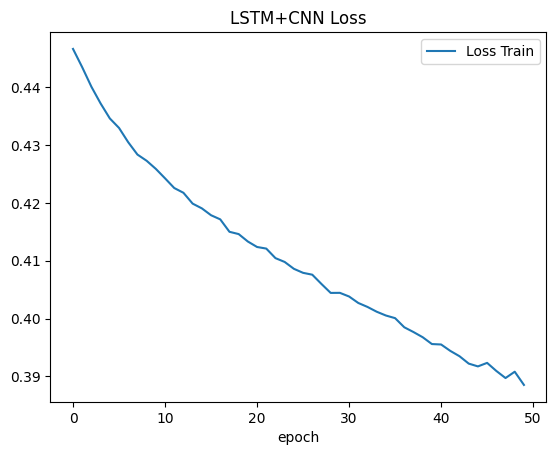

In [219]:
plt.plot(losses_train, label='Loss Train')
plt.xlabel('epoch')
plt.title('LSTM+CNN Loss')
plt.legend()
plt.show()

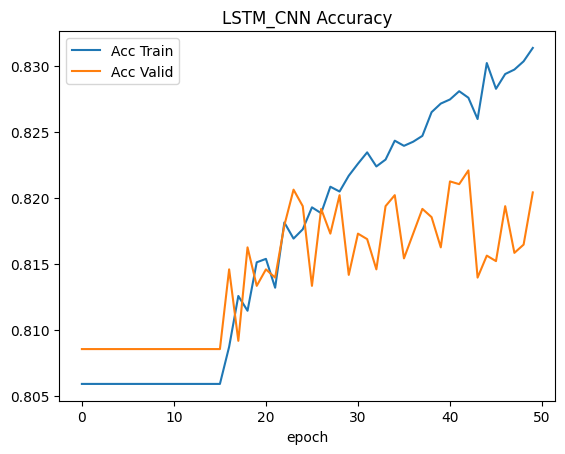

In [220]:
plt.plot(acc_train, label='Acc Train')
plt.plot(acc_valid, label='Acc Valid')
plt.xlabel('epoch')
plt.title('LSTM_CNN Accuracy')
plt.legend()
plt.show()

In [221]:

pr, ac, rc, auc = getMetrics(test_dataloader, model)
print('Testing Metrics: \nPrecision: \t{:.4f} \nAccuracy: \t{:.4f} \nRecall: \t{:.4f} \nAUC: \t\t{:.4f}'.format(pr, ac, rc, auc))

Testing Metrics: 
Precision: 	0.5364 
Accuracy: 	0.8238 
Recall: 	0.2761 
AUC: 		0.0000
